# Testing of the Model

Make sure the paths below exists. Download the datasets from:

* ISTD: https://drive.google.com/file/d/1I0qw-65KBA6np8vIZzO6oeiOvcDBttAY/view
* USR: https://drive.google.com/file/d/1PPAX0W4eyfn1cUrb2aBefnbrmhB1htoJ/view

Place them under a folder named "datasets". This notebook should be located as:

* cycleGAN_test.ipynb (this notebook)
* datasets (folder including ISTD and USR folders)
* output (folder including the pre-trained model as given in "model_path=...")

When you run the notebook, the results will be saved under "output" folder.

### Dependencies
Install the dependencies if they are missing.

In [2]:
!pip install tensorflow
!pip install matplotlib
!pip install tensorflow_addons
!pip install keras

In [3]:
# Import required packages
import os
import sys
import datetime
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

from os import listdir
from keras.models import load_model
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.preprocessing import image


### Edit me
Provide the paths for:

    1) Model (location of the model .h5 file)
    2) Dataset (location of the ISTD or USR datasets)
    3) Output (where the outputs will be saved, './' saves them relative to this notebook)
    
    

In [16]:
# Edit the path of the pretrained model and the dataset
# Output path is where the output of the models will be

# Select one of them:
model_path_pair = './output/pretrained_models/pair/generator_free_model_001000.h5'
model_path_unpair = './output/pretrained_models/unpair/generator_free_model_001000.h5'

dataset_path = './datasets/ISTD/' # USR is also used at the end of this notebook
output_path = './output/'

In [17]:
# load images in a directory into memory
# dataset_size: set how many images will be loaded; if None, all images will be loaded
def load_images(path, size, dataset_size=None):
    data_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        
        try:
            # load and resize the image
            pixels = image.load_img(path + filename, target_size=size)
        except:
            print(">> Encountered non-image file, skipping ", filename)
            continue # some files like .DS_Store may be caught
        
        # convert to numpy array
        pixels = image.img_to_array(pixels)
        # store
        data_list.append(pixels)
        if dataset_size:
            dataset_size -= 1
            if dataset_size == 0:
                break
    return np.asarray(data_list)


In [18]:
# Select random samples given a dataset and number of samples 
# If idx is set, select corresponding samples from given indices
# E.g. idx=[0,3,5] returns the instances at 0th, 3rd, and 5th locations
def select_sample(dataset, n_samples=5, idx=None):
    # choose random instances
    if idx is None:
        idx = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    x = dataset[idx]
    return x, idx

In [31]:
def plot_model_output(random_samples_free, random_samples_shadow, output_pair, output_unpair, path_output):
    num_samples, _, _, _ = random_samples_free.shape
    images = np.concatenate((random_samples_shadow, random_samples_free, output_pair, output_unpair), axis=0)
    images = ((images + 1) / 2.0) * 255.

    #title = 'Shadow\nFree-Original\nFree-Generated'

    for j in range(4):
        for i in range(j*num_samples, (j+1)*num_samples):
            plt.subplot(4, num_samples, i+1)
            plt.imshow(images[i].astype(np.uint8))
            plt.axis('off')
    #plt.suptitle(title)

    # save plot to file
    foldername = 'results'
    path_results = os.path.join(path_output, foldername)
    if foldername not in os.listdir(path_output):
        os.mkdir(path_results)
    filename = 'results %s.png' % datetime.datetime.now()
    save_path = os.path.join(path_results, filename)
    plt.savefig(save_path)
    #plt.close()

In [26]:
def plot_USR(random_samples_shadow, model_output, path_output):
    num_samples, _, _, _ = random_samples_shadow.shape
    images = np.concatenate((random_samples_shadow, model_output), axis=0)
    images = ((images + 1) / 2.0) * 255.

    for j in range(2):
        for i in range(j*num_samples, (j+1)*num_samples):
            plt.subplot(2, num_samples, i+1)
            plt.imshow(images[i].astype(np.uint8))
            plt.axis('off')

    # save plot to file
    foldername = 'results'
    path_results = os.path.join(path_output, foldername)
    if foldername not in os.listdir(path_output):
        os.mkdir(path_results)
    filename = 'results_usr_%s.png' % datetime.datetime.now()
    save_path = os.path.join(path_results, filename)
    plt.savefig(save_path)
    #plt.close()

In [27]:
def plot_model_output(random_samples_free, random_samples_shadow, model_output, path_output):
    num_samples, _, _, _ = random_samples_free.shape
    images = np.concatenate((random_samples_shadow, random_samples_free, model_output), axis=0)
    images = ((images + 1) / 2.0) * 255.

    title = 'Shadow\nFree-Original\nFree-Generated'

    for j in range(3):
        for i in range(j*num_samples, (j+1)*num_samples):
            plt.subplot(3, num_samples, i+1)
            plt.imshow(images[i].astype(np.uint8))
            plt.axis('off')
    #plt.suptitle(title)

    # save plot to file
    foldername = 'results'
    path_results = os.path.join(path_output, foldername)
    if foldername not in os.listdir(path_output):
        os.mkdir(path_results)
    filename = 'results %s.png' % datetime.datetime.now()
    save_path = os.path.join(path_results, filename)
    plt.savefig(save_path)
    #plt.close()

In [28]:
# Load the dataset images (test)
data_shadow = load_images(dataset_path + 'test/test_A/', size=(512, 512)) # 'A' is the shadow images (X)
data_free = load_images(dataset_path + 'test/test_C/', size=(512, 512))   # 'C' is the shadow-free images (Y)

# Preprocess the images from [0,255] range to the model range [-1, 1] (see original paper)
data_shadow = (data_shadow/255.) * 2.0 - 1.0
data_free = (data_free/255.) * 2.0 - 1.0

print(">> Loaded ",data_free.shape," shadow-free and ",data_shadow.shape, "shadow images")

>> Loaded  (540, 512, 512, 3)  shadow-free and  (540, 512, 512, 3) shadow images


In [29]:
# Load the pre-trained model for testing 
# The generator that frees the shadow is loaded to remove the shadows in the test cases

gen_f_pair = load_model(model_path_pair,custom_objects={'InstanceNormalization':InstanceNormalization})
gen_f_unpair = load_model(model_path_unpair,custom_objects={'InstanceNormalization':InstanceNormalization})


## Plot the results
You can run the cell below repeatedly to plot different samples from the test dataset

Selected indices:  [33, 417, 162, 1, 2]
Top: Original shadow images
Middle: Original shadow-free images
Bottom1: Generated shadow-free images (paired data)
Bottom1: Generated shadow-free images (unpaired data)


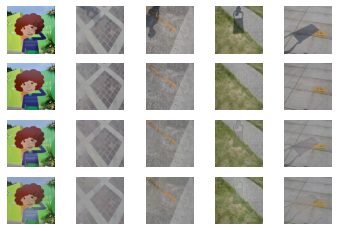

In [37]:
# Select some of the samples 
# Performs good on :17, 181, 183, 190, 519, 256, 458, 462, 461, 78, 33, 417, 162
# Performs worse on: 173, 372, 533, 366, 481, 229, 399
random_samples_shadow, idx = select_sample(data_shadow, idx=[33, 417, 162, 1,2]) 
random_samples_free = data_free[idx]

# Obtain the model output for shadow images
model_output_pair = gen_f_pair(random_samples_shadow).numpy()
model_output_unpair = gen_f_unpair(random_samples_shadow).numpy()

# Plot the original shadow and shadow-free images with the generated shadow-free image
plot_model_output(random_samples_free, random_samples_shadow, model_output_pair, model_output_unpair, output_path)

print("Selected indices: ", idx)
print("Top: Original shadow images")
print("Middle: Original shadow-free images")
print("Bottom1: Generated shadow-free images (paired data)")
print("Bottom1: Generated shadow-free images (unpaired data)")

## Quantitative Analysis

Compare the obtained results with original paper.

In [15]:
# Convert images from range [-1,1] to [0,1]
a = generated_free = (model_output+1)/2.
b = original_free = (random_samples_free+1)/2.

# Measure Peak Signal to Noise Ratio (PSNR)
psnr = tf.reduce_mean(tf.image.psnr(a, b, 255.)).numpy()

# Measure Root Mean Squared Error (RMSE)
rmse = tf.sqrt(tf.reduce_mean(tf.square(a-b))).numpy()

print("PSNR: ", psnr)
print("RMSE: ", rmse)

PSNR:  69.83412
RMSE:  0.086570494
